# Imports

In [ ]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
import random
from datetime import datetime
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa

from keras.models import Sequential
from keras.layers import AveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.densenet import DenseNet
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Dataset Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir /content/dataset/
!mkdir /content/dataset/diabetes

In [ ]:
!unzip '/content/drive/MyDrive/datasets/diabetes/diabetic-retinopathy-resized-arranged.zip' -d '/content/dataset/diabetes/train'

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/dataset/diabetes/train/2/23798_right.jpeg  
  inflating: /content/dataset/diabetes/train/2/23817_left.jpeg  
  inflating: /content/dataset/diabetes/train/2/23817_right.jpeg  
  inflating: /content/dataset/diabetes/train/2/23821_left.jpeg  
  inflating: /content/dataset/diabetes/train/2/23821_right.jpeg  
  inflating: /content/dataset/diabetes/train/2/23852_left.jpeg  
  inflating: /content/dataset/diabetes/train/2/23854_left.jpeg  
  inflating: /content/dataset/diabetes/train/2/23905_left.jpeg  
  inflating: /content/dataset/diabetes/train/2/23905_right.jpeg  
  inflating: /content/dataset/diabetes/train/2/23906_left.jpeg  
  inflating: /content/dataset/diabetes/train/2/23923_left.jpeg  
  inflating: /content/dataset/diabetes/train/2/23923_right.jpeg  
  inflating: /content/dataset/diabetes/train/2/23946_left.jpeg  
  inflating: /content/dataset/diabetes/train/2/23946_right.jpeg  
  inflating: /content/dat

In [ ]:
import os, shutil, sys 

!mkdir /content/dataset/diabetes/test

def move_to_folder(cur_path, new_path):
    for i in range(5):
      os.mkdir(new_path + str(i))
      files = sorted(os.listdir(cur_path + str(i)))[:6]
      for filename in files:
        shutil.move(os.path.join(cur_path + str(i), filename), os.path.join(new_path + str(i), filename))

move_to_folder('/content/dataset/diabetes/train/', '/content/dataset/diabetes/test/')

In [ ]:
os.rename('/content/dataset/diabetes/train/0', '/content/dataset/diabetes/train/no_dr')
os.rename('/content/dataset/diabetes/train/1', '/content/dataset/diabetes/train/mild')
os.rename('/content/dataset/diabetes/train/2', '/content/dataset/diabetes/train/moderate')
os.rename('/content/dataset/diabetes/train/3', '/content/dataset/diabetes/train/severe')
os.rename('/content/dataset/diabetes/train/4', '/content/dataset/diabetes/train/proliferative_dr')

os.rename('/content/dataset/diabetes/test/0', '/content/dataset/diabetes/test/no_dr')
os.rename('/content/dataset/diabetes/test/1', '/content/dataset/diabetes/test/mild')
os.rename('/content/dataset/diabetes/test/2', '/content/dataset/diabetes/test/moderate')
os.rename('/content/dataset/diabetes/test/3', '/content/dataset/diabetes/test/severe')
os.rename('/content/dataset/diabetes/test/4', '/content/dataset/diabetes/test/proliferative_dr')

# Hyperparameters Setup

In [ ]:
IMAGE_SIZE = 299
BATCH_SIZE = 32
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
LEARNING_RATE = 0.001
NUM_EPOCHS = 20

CLASSES = ['no_dr', 'mild', 'moderate', 'severe', 'proliferative_dr']

# Model Setup

In [ ]:
# preprocessing/augmentation for ImageDataGenerator
def preprocesser(image):
    image= tf.image.adjust_contrast(image, 0.6)
    image = tfa.image.equalize(image)
    image = tf.image.rgb_to_grayscale(image)
    return image

In [ ]:
DF_TRAIN = '/content/dataset/diabetes/train'
DF_TEST  = '/content/dataset/diabetes/test'

# images generator
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                           validation_split = 0.2,
                                                           preprocessing_function = preprocesser)

train_set = data_gen.flow_from_directory(DF_TRAIN,
                                         subset = 'training',
                                         seed = 569,
                                         color_mode = 'rgb',
                                         shuffle = True,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                         class_mode = 'categorical')

valid_set = data_gen.flow_from_directory(DF_TRAIN,
                                         subset = 'validation',
                                         seed = 343,
                                         color_mode = 'rgb',
                                         shuffle = False,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                         class_mode = 'categorical')

test_set  = data_gen.flow_from_directory(DF_TEST,
                                         seed = 348,
                                         color_mode = 'rgb',
                                         shuffle = False,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                         class_mode = 'categorical')

STEP_SIZE_TRAIN = train_set.n // train_set.batch_size
STEP_SIZE_VALID = valid_set.n // valid_set.batch_size

Found 28079 images belonging to 5 classes.
Found 7017 images belonging to 5 classes.
Found 30 images belonging to 5 classes.


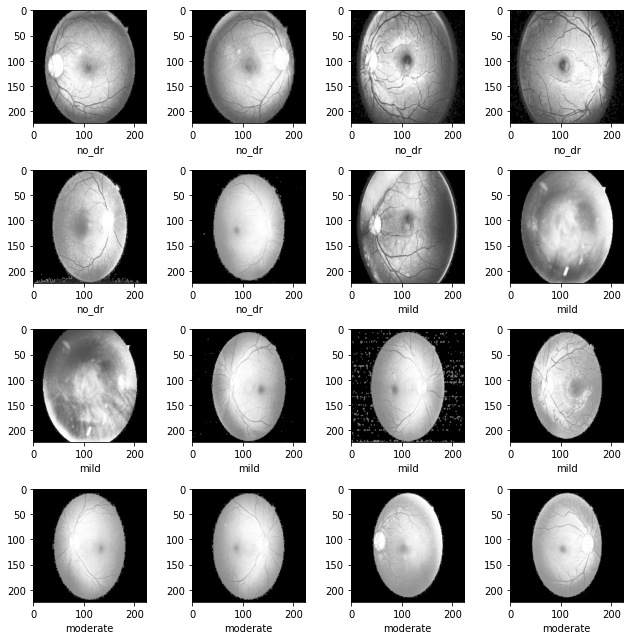

In [ ]:
images, labels = next(test_set)[:16]
fig, axes = plt.subplots(4, 4, figsize = (9, 9))

axes = axes.flatten()
for img, label, ax in zip(images, labels, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    idx = np.take(np.where(label == 1), 0)
    ax.set_xlabel(CLASSES[idx])
    ax.axis('on')
plt.tight_layout()
plt.show()

# Build Model

In [ ]:
# create base model
base_model = DenseNet(input_shape = INPUT_SHAPE,
                      include_top=False,
                      weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# add dense layers to CNN
model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units = 500, activation = 'relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units = 5, activation = 'softmax', name = 'Output'),
    ],
    name = 'resnet50_model')

model.summary()

Model: "vgg16_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 500)               12544500  
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 Output (Dense)              (None, 5)                 2505      
                                                                 
Total params: 27,261,693
Trainable params: 12,547,005
Non-trainable params: 14,714,688
_________________________________________________________________


# Model Training

In [ ]:
# compile classifier
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE), 
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
    metrics=[
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    ],
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

In [ ]:
# train the model
start = datetime.now()
print(datetime.now())

history = model.fit(train_set, 
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    epochs = NUM_EPOCHS, 
                    validation_data = valid_set,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = callbacks)

end = datetime.now()
print(end-start)

2021-11-20 11:34:31.066025
Epoch 1/20
877/877 [==============================] - ETA: 0s - loss: 0.8851 - accuracy: 0.7350
Epoch 00001: val_accuracy improved from -inf to 0.73630, saving model to ./model.hdf5
877/877 [==============================] - 588s 671ms/step - loss: 0.8851 - accuracy: 0.7350 - val_loss: 0.8218 - val_accuracy: 0.7363 - lr: 0.0010
Epoch 2/20
309/877 [=========>....................] - ETA: 5:03 - loss: 0.8564 - accuracy: 0.7314

# Model Evaluate

In [ ]:
# evaluate accuracy and loss
(eval_loss, eval_accuracy) = model.evaluate(valid_set, batch_size = BATCH_SIZE, verbose = 1)

In [ ]:
# show results
print('Evaluate:')
print('---------------')
print("accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("loss: {}".format(eval_loss)) 

# Predict

In [ ]:
# check class indices and labels
valid_set.class_indices

In [ ]:
# predict classes from test dataset
test_set.reset()
Y_pred = model.predict(test_set, steps = test_set.n // test_set.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

true_classes = len(test_set.class_indices)
class_values = list(test_set.class_indices.values())
class_labels = list(test_set.class_indices.keys())

print('Classification Report')
print(classification_report(test_set.classes, y_pred))

print('Confusion Matrix')
confusionmatrix = confusion_matrix(test_set.classes, y_pred, labels = class_values)
plt.figure(figsize = (10, 10))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)